In [1]:
trial_number_ml = "002"
random_state_init = 420

In [2]:
# %%
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# optuna
import optuna
import optuna.integration.lightgbm as lgb_optuna
from optuna.pruners import MedianPruner
from optuna.integration import OptunaSearchCV

#xgboost
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance


# metrics
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score, make_scorer, precision_recall_curve
from sklearn.model_selection import cross_val_score, StratifiedKFold

#lightgbm
import lightgbm as lgb
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns


from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole # Enables RDKit's IPython integration for Jupyter notebooks.
from IPython.display import display


import os
from rdkit.Chem.Draw import rdMolDraw2D

import joblib


# %%
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
import os

# Get the current working directory
current_dir = os.getcwd()
print("Current Directory:", current_dir)

# Verify the change
new_dir = os.getcwd()
print("New Working Directory:", new_dir)


Current Directory: /home/ubuntu/diplomka/notebooks_ipynb/ml/model2_rna_prot_bin
New Working Directory: /home/ubuntu/diplomka/notebooks_ipynb/ml/model2_rna_prot_bin


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

def load_and_concatenate_datasets(file_paths):
    """
    Load datasets from given file paths and concatenate them into a single DataFrame.
    """
    dataframes = [pd.read_pickle(path) for path in file_paths]
    return pd.concat(dataframes, ignore_index=True)

def preprocess_data(df, feature_col='ecfp6', label_col='label'):
    """
    Preprocess the DataFrame by extracting features and labels.
    """
    X = np.array([list(map(int, list(fp))) for fp in df[feature_col]])
    y = df[label_col].values
    return X, y

def stratified_train_test_split(X, y, test_size=0.2, random_state=42):
    """
    Split the dataset into training and test sets, ensuring stratification of the target variable.
    """
    return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

# Paths for the datasets
model2_files = ['../../data_for_ml/ml_datasets_set2/model2_rna_bin_protein_bin/data.pkl']

# Load datasets
model2_df = load_and_concatenate_datasets(model2_files)

# Preprocess datasets
X2, y2 = preprocess_data(model2_df)

# Split datasets
X_train, X_test, y_train, y_test = stratified_train_test_split(X2, y2)

# Output shapes
print(f"Model 2 - Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")


Model 2 - Training set size: 3137, Test set size: 785


In [5]:
import numpy as np
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from optuna.integration import OptunaSearchCV


def model_training_and_evaluation(model, X_train, y_train, X_test, y_test):
    """
    Train and evaluate a model using given datasets.
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return model, accuracy

def objective(trial, model_cls, X_train, y_train):
    """
    Objective function for hyperparameter tuning with Optuna.
    
    Args:
    - trial (optuna.trial.Trial): An individual trial object.
    - model_cls: The classifier class to be optimized.
    - X_train, y_train: Training data.
    
    Returns:
    - The accuracy of the model on the cross-validation folds.
    """
    # Suggest hyperparameters specific to the RandomForestClassifier
    if model_cls == RandomForestClassifier:
        n_estimators = trial.suggest_int('n_estimators', 100, 1000)
        max_depth = trial.suggest_int('max_depth', 10, 100)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
        max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
        
        model = model_cls(n_estimators=n_estimators, max_depth=max_depth,
                          min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                          max_features=max_features, random_state=random_state_init, n_jobs=4)
        
    elif model_cls == XGBClassifier:
        n_estimators = trial.suggest_int('n_estimators', 100, 1000, log=True)
        max_depth = trial.suggest_int('max_depth', 3, 10)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
        min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
        subsample = trial.suggest_float('subsample', 0.5, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
        gamma = trial.suggest_float('gamma', 0, 5)
        reg_lambda = trial.suggest_float('reg_lambda', 0.01, 10.0, log=True)
        reg_alpha = trial.suggest_float('reg_alpha', 0.01, 10.0, log=True)

        model = model_cls(n_estimators=n_estimators, max_depth=max_depth,
                        learning_rate=learning_rate, min_child_weight=min_child_weight,
                        subsample=subsample, colsample_bytree=colsample_bytree,
                        gamma=gamma, reg_lambda=reg_lambda, reg_alpha=reg_alpha,
                        random_state=random_state_init, use_label_encoder=False, eval_metric='logloss', n_jobs=4)
    
    elif model_cls == LGBMClassifier:
        boosting_type = trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss'])
        num_leaves = trial.suggest_int('num_leaves', 31, 100)
        max_depth = trial.suggest_int('max_depth', -1, 15)
        learning_rate = trial.suggest_float('learning_rate', 0.001, 0.5)
        n_estimators = trial.suggest_int('n_estimators', 100, 1000)
        min_child_weight = trial.suggest_float('min_child_weight', 1e-3, 1e-1, log=True)
        min_child_samples = trial.suggest_int('min_child_samples', 20, 2000)
        subsample = trial.suggest_float('subsample', 0.8, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.8, 1.0)
        reg_alpha = trial.suggest_float('reg_alpha', 1e-10, 1.0, log=True)
        reg_lambda = trial.suggest_float('reg_lambda', 1e-10, 1.0, log=True)
        
        model = model_cls(boosting_type=boosting_type, num_leaves=num_leaves, max_depth=max_depth,
                        learning_rate=learning_rate, n_estimators=n_estimators,
                        min_child_weight=min_child_weight, min_child_samples=min_child_samples,
                        subsample=subsample, colsample_bytree=colsample_bytree,
                        reg_alpha=reg_alpha, reg_lambda=reg_lambda, random_state=random_state_init, verbosity=-1, n_jobs=4)
    else:
        raise NotImplementedError("Optuna objective function needs to be extended for other classifiers.")
    
    # Cross-validation within the Optuna trial
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state_init)
    accuracies = []
    for train_index, val_index in stratified_kfold.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train[train_index], X_train[val_index]
        y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
        
        model.fit(X_fold_train, y_fold_train)
        y_fold_pred = model.predict(X_fold_val)
        accuracy = accuracy_score(y_fold_val, y_fold_pred)
        accuracies.append(accuracy)
        
        trial.report(np.mean(accuracies), len(accuracies))
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    return np.mean(accuracies)

def perform_hyperparameter_tuning(model_cls, X_train, y_train, n_trials=50):
    """
    Perform hyperparameter tuning for the given model class using Optuna.
    """
    study = optuna.create_study(direction='maximize')
    objective_with_model = lambda trial: objective(trial, model_cls, X_train, y_train)
    study.optimize(objective_with_model, n_trials=n_trials, n_jobs=4) 
    
    print(f"Best trial for {model_cls.__name__}:")
    print(f"  Value: {study.best_trial.value}")
    print("  Params: ")
    for key, value in study.best_trial.params.items():
        print(f"    {key}: {value}")
    print('')
    return study.best_params

print('')
# Example usage for RandomForestClassifier
best_params_rf = perform_hyperparameter_tuning(RandomForestClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for RandomForestClassifier:", best_params_rf)
# Train and evaluate the final model with the best hyperparameters
best_rf = RandomForestClassifier(**best_params_rf, random_state=random_state_init)
final_model, final_accuracy = model_training_and_evaluation(best_rf, X_train, y_train, X_test, y_test)
print(f"RandomForestClassifier accuracy: {final_accuracy:.4f}")
print('')

# Example usage for XGBClassifier
best_params_xgb = perform_hyperparameter_tuning(XGBClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for XGBClassifier:", best_params_xgb)
# Train and evaluate the final model with the best hyperparameters
best_xgb = XGBClassifier(**best_params_xgb, random_state=random_state_init, use_label_encoder=False, eval_metric='logloss')
final_model, final_accuracy = model_training_and_evaluation(best_xgb, X_train, y_train, X_test, y_test)
print(f"XGBClassifier accuracy: {final_accuracy:.4f}")
print('')

# Example usage for LGBMClassifier
best_params_lgb = perform_hyperparameter_tuning(LGBMClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for LGBMClassifier:", best_params_lgb)
# Train and evaluate the final model with the best hyperparameters
best_lgb = LGBMClassifier(**best_params_lgb, random_state=random_state_init, verbosity=-1)
final_model, final_accuracy = model_training_and_evaluation(best_lgb, X_train, y_train, X_test, y_test)
print(f"LGBMClassifier accuracy: {final_accuracy:.4f}")

print(f"LGBMClassifier accuracy: {final_accuracy:.4f}")
print('')


[I 2024-05-01 15:07:01,019] A new study created in memory with name: no-name-e2ce06cb-a823-46a6-ab50-81d1b7571073


[I 2024-05-01 15:07:32,044] Trial 3 finished with value: 0.8409278842735095 and parameters: {'n_estimators': 183, 'max_depth': 66, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 3 with value: 0.8409278842735095.


[I 2024-05-01 15:08:00,573] Trial 4 finished with value: 0.8300846209327604 and parameters: {'n_estimators': 157, 'max_depth': 18, 'min_samples_split': 19, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.8409278842735095.


[I 2024-05-01 15:08:28,420] Trial 2 finished with value: 0.8638791535875008 and parameters: {'n_estimators': 420, 'max_depth': 40, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.8638791535875008.


[I 2024-05-01 15:08:32,443] Trial 1 finished with value: 0.8527194506242445 and parameters: {'n_estimators': 478, 'max_depth': 53, 'min_samples_split': 17, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.8638791535875008.


[I 2024-05-01 15:08:34,058] Trial 5 finished with value: 0.8186100021333008 and parameters: {'n_estimators': 228, 'max_depth': 25, 'min_samples_split': 3, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 2 with value: 0.8638791535875008.


[I 2024-05-01 15:08:50,444] Trial 8 pruned. 


[I 2024-05-01 15:09:36,639] Trial 0 finished with value: 0.8380565629476122 and parameters: {'n_estimators': 894, 'max_depth': 89, 'min_samples_split': 18, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.8638791535875008.


[I 2024-05-01 15:10:24,853] Trial 7 finished with value: 0.8450741068072614 and parameters: {'n_estimators': 655, 'max_depth': 97, 'min_samples_split': 20, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 2 with value: 0.8638791535875008.


[I 2024-05-01 15:10:51,120] Trial 6 finished with value: 0.8358232001544105 and parameters: {'n_estimators': 757, 'max_depth': 18, 'min_samples_split': 16, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.8638791535875008.


[I 2024-05-01 15:11:06,062] Trial 11 finished with value: 0.8396489196355104 and parameters: {'n_estimators': 190, 'max_depth': 48, 'min_samples_split': 14, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.8638791535875008.


[I 2024-05-01 15:11:23,618] Trial 9 finished with value: 0.8501701561373032 and parameters: {'n_estimators': 786, 'max_depth': 99, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.8638791535875008.


[I 2024-05-01 15:11:38,122] Trial 10 finished with value: 0.8584641249911111 and parameters: {'n_estimators': 730, 'max_depth': 70, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 2 with value: 0.8638791535875008.


[I 2024-05-01 15:12:08,154] Trial 13 finished with value: 0.8702551834130781 and parameters: {'n_estimators': 413, 'max_depth': 77, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.8702551834130781.


[I 2024-05-01 15:12:20,218] Trial 12 finished with value: 0.854315362813519 and parameters: {'n_estimators': 605, 'max_depth': 88, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.8702551834130781.


[I 2024-05-01 15:12:30,194] Trial 14 finished with value: 0.8702556913418462 and parameters: {'n_estimators': 422, 'max_depth': 66, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.8702556913418462.


[I 2024-05-01 15:12:40,712] Trial 15 finished with value: 0.8712146608559616 and parameters: {'n_estimators': 415, 'max_depth': 72, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 15 with value: 0.8712146608559616.


[I 2024-05-01 15:13:36,497] Trial 16 finished with value: 0.8696187486666871 and parameters: {'n_estimators': 420, 'max_depth': 32, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 15 with value: 0.8712146608559616.


[I 2024-05-01 15:13:46,785] Trial 19 finished with value: 0.8670653907496012 and parameters: {'n_estimators': 332, 'max_depth': 63, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 15 with value: 0.8712146608559616.


[I 2024-05-01 15:13:47,351] Trial 18 finished with value: 0.8689802822052236 and parameters: {'n_estimators': 331, 'max_depth': 71, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 15 with value: 0.8712146608559616.


[I 2024-05-01 15:13:52,470] Trial 17 finished with value: 0.8699362041467305 and parameters: {'n_estimators': 408, 'max_depth': 31, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 15 with value: 0.8712146608559616.


[I 2024-05-01 15:13:56,546] Trial 21 pruned. 


[I 2024-05-01 15:13:56,611] Trial 22 pruned. 


[I 2024-05-01 15:14:09,375] Trial 23 pruned. 


[I 2024-05-01 15:14:14,567] Trial 24 pruned. 


[I 2024-05-01 15:14:36,011] Trial 20 finished with value: 0.867070470037282 and parameters: {'n_estimators': 319, 'max_depth': 62, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 15 with value: 0.8712146608559616.


[I 2024-05-01 15:15:28,846] Trial 25 finished with value: 0.8626037444508782 and parameters: {'n_estimators': 481, 'max_depth': 60, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 15 with value: 0.8712146608559616.


[I 2024-05-01 15:15:34,758] Trial 26 finished with value: 0.8616473145806033 and parameters: {'n_estimators': 471, 'max_depth': 60, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 15 with value: 0.8712146608559616.


[I 2024-05-01 15:15:36,976] Trial 27 finished with value: 0.8632427188411096 and parameters: {'n_estimators': 452, 'max_depth': 60, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 15 with value: 0.8712146608559616.


[I 2024-05-01 15:15:42,003] Trial 30 pruned. 


[I 2024-05-01 15:15:52,821] Trial 28 finished with value: 0.862923231645994 and parameters: {'n_estimators': 455, 'max_depth': 55, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 15 with value: 0.8712146608559616.


[I 2024-05-01 15:16:03,417] Trial 33 pruned. 


[I 2024-05-01 15:16:06,505] Trial 32 pruned. 


[I 2024-05-01 15:16:33,532] Trial 35 pruned. 


[I 2024-05-01 15:17:38,838] Trial 36 finished with value: 0.8724849907049036 and parameters: {'n_estimators': 398, 'max_depth': 38, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 36 with value: 0.8724849907049036.


[I 2024-05-01 15:17:53,852] Trial 29 finished with value: 0.8565466938916486 and parameters: {'n_estimators': 997, 'max_depth': 87, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 36 with value: 0.8724849907049036.


[I 2024-05-01 15:18:00,464] Trial 31 finished with value: 0.8565472018204167 and parameters: {'n_estimators': 993, 'max_depth': 92, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 36 with value: 0.8724849907049036.


[I 2024-05-01 15:18:43,823] Trial 34 finished with value: 0.8759912229908877 and parameters: {'n_estimators': 990, 'max_depth': 74, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 34 with value: 0.8759912229908877.


[I 2024-05-01 15:19:18,616] Trial 39 finished with value: 0.8708906023019332 and parameters: {'n_estimators': 387, 'max_depth': 42, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 34 with value: 0.8759912229908877.


[I 2024-05-01 15:19:27,050] Trial 37 finished with value: 0.8737619236278305 and parameters: {'n_estimators': 582, 'max_depth': 41, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 34 with value: 0.8759912229908877.


[I 2024-05-01 15:19:40,542] Trial 41 pruned. 


[I 2024-05-01 15:19:45,053] Trial 43 pruned. 


[I 2024-05-01 15:19:52,912] Trial 38 finished with value: 0.8728060016863235 and parameters: {'n_estimators': 578, 'max_depth': 41, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 34 with value: 0.8759912229908877.


[I 2024-05-01 15:19:59,104] Trial 42 pruned. 


[I 2024-05-01 15:20:29,899] Trial 46 pruned. 


[I 2024-05-01 15:21:11,015] Trial 40 finished with value: 0.8705731468218897 and parameters: {'n_estimators': 588, 'max_depth': 40, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 34 with value: 0.8759912229908877.


[I 2024-05-01 15:22:34,220] Trial 44 finished with value: 0.8718495718160485 and parameters: {'n_estimators': 664, 'max_depth': 39, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 34 with value: 0.8759912229908877.


[I 2024-05-01 15:22:45,512] Trial 45 finished with value: 0.8661099767368625 and parameters: {'n_estimators': 683, 'max_depth': 49, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 34 with value: 0.8759912229908877.


[I 2024-05-01 15:23:01,826] Trial 49 pruned. 


[I 2024-05-01 15:23:08,149] Trial 47 finished with value: 0.8705726388931216 and parameters: {'n_estimators': 696, 'max_depth': 49, 'min_samples_split': 13, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 34 with value: 0.8759912229908877.


[I 2024-05-01 15:23:14,484] Trial 48 finished with value: 0.8661115005231667 and parameters: {'n_estimators': 704, 'max_depth': 49, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 34 with value: 0.8759912229908877.


Best trial for RandomForestClassifier:
  Value: 0.8759912229908877
  Params: 
    n_estimators: 990
    max_depth: 74
    min_samples_split: 2
    min_samples_leaf: 1
    max_features: sqrt

Best hyperparameters for RandomForestClassifier: {'n_estimators': 990, 'max_depth': 74, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}


[I 2024-05-01 15:23:36,582] A new study created in memory with name: no-name-8eafac61-5e95-4b6f-af6e-613d2e006c99


RandomForestClassifier accuracy: 0.8650



[I 2024-05-01 15:23:49,206] Trial 2 finished with value: 0.8501737116386797 and parameters: {'n_estimators': 181, 'max_depth': 3, 'learning_rate': 0.27610732926336373, 'min_child_weight': 7, 'subsample': 0.6415722599622605, 'colsample_bytree': 0.9732502080443795, 'gamma': 2.370583188714272, 'reg_lambda': 0.010713547330947494, 'reg_alpha': 0.16039127329666228}. Best is trial 2 with value: 0.8501737116386797.


[I 2024-05-01 15:23:50,779] Trial 0 finished with value: 0.853357917085708 and parameters: {'n_estimators': 317, 'max_depth': 9, 'learning_rate': 0.10506495202298792, 'min_child_weight': 4, 'subsample': 0.7745890191234015, 'colsample_bytree': 0.8368111379959715, 'gamma': 4.47652595635653, 'reg_lambda': 2.0718402486385643, 'reg_alpha': 0.44153957458408694}. Best is trial 0 with value: 0.853357917085708.


[I 2024-05-01 15:23:54,732] Trial 3 finished with value: 0.8412488952549294 and parameters: {'n_estimators': 408, 'max_depth': 4, 'learning_rate': 0.18503766413771497, 'min_child_weight': 9, 'subsample': 0.8423756325016258, 'colsample_bytree': 0.7671855598726974, 'gamma': 1.7620734868710923, 'reg_lambda': 0.09765521840702328, 'reg_alpha': 4.174264948524627}. Best is trial 0 with value: 0.853357917085708.


[I 2024-05-01 15:24:00,578] Trial 6 finished with value: 0.8307256270380641 and parameters: {'n_estimators': 107, 'max_depth': 4, 'learning_rate': 0.2516855139162886, 'min_child_weight': 6, 'subsample': 0.6086094879984885, 'colsample_bytree': 0.7167306383161904, 'gamma': 4.9253101279572515, 'reg_lambda': 5.396098613084961, 'reg_alpha': 1.0616289409451665}. Best is trial 0 with value: 0.853357917085708.


[I 2024-05-01 15:24:02,233] Trial 4 finished with value: 0.8629222157884577 and parameters: {'n_estimators': 222, 'max_depth': 10, 'learning_rate': 0.09090872578549149, 'min_child_weight': 4, 'subsample': 0.8577174741032314, 'colsample_bytree': 0.84625046410297, 'gamma': 3.154620056044744, 'reg_lambda': 3.629853407659728, 'reg_alpha': 0.2918297919511296}. Best is trial 4 with value: 0.8629222157884577.


[I 2024-05-01 15:24:02,381] Trial 1 pruned. 


[I 2024-05-01 15:24:03,183] Trial 7 pruned. 


[I 2024-05-01 15:24:04,724] Trial 8 pruned. 


[I 2024-05-01 15:24:07,627] Trial 10 pruned. 


[I 2024-05-01 15:24:07,680] Trial 11 pruned. 


[I 2024-05-01 15:24:13,998] Trial 9 finished with value: 0.8600529261776328 and parameters: {'n_estimators': 179, 'max_depth': 9, 'learning_rate': 0.11852673066526183, 'min_child_weight': 4, 'subsample': 0.9440487461640052, 'colsample_bytree': 0.6327943707052579, 'gamma': 2.4782552286293322, 'reg_lambda': 0.3266298445908159, 'reg_alpha': 1.785631598651001}. Best is trial 4 with value: 0.8629222157884577.


[I 2024-05-01 15:24:19,175] Trial 5 finished with value: 0.8523989475715925 and parameters: {'n_estimators': 647, 'max_depth': 9, 'learning_rate': 0.035367208819736776, 'min_child_weight': 4, 'subsample': 0.5614484023107149, 'colsample_bytree': 0.5110343437997276, 'gamma': 4.409253016875068, 'reg_lambda': 0.3008301198645338, 'reg_alpha': 1.3597892024641751}. Best is trial 4 with value: 0.8629222157884577.


[I 2024-05-01 15:24:21,103] Trial 12 finished with value: 0.8536768963520556 and parameters: {'n_estimators': 282, 'max_depth': 7, 'learning_rate': 0.1020238344763986, 'min_child_weight': 2, 'subsample': 0.8886443310876212, 'colsample_bytree': 0.8574249589801314, 'gamma': 3.7300746640466538, 'reg_lambda': 8.053195226110805, 'reg_alpha': 0.12239983190207078}. Best is trial 4 with value: 0.8629222157884577.


[I 2024-05-01 15:24:22,972] Trial 13 finished with value: 0.8546302786497222 and parameters: {'n_estimators': 139, 'max_depth': 7, 'learning_rate': 0.02307196000423349, 'min_child_weight': 2, 'subsample': 0.9478360345461874, 'colsample_bytree': 0.602598707463144, 'gamma': 0.001585363570435927, 'reg_lambda': 8.71784125882134, 'reg_alpha': 0.1198052538960886}. Best is trial 4 with value: 0.8629222157884577.


[I 2024-05-01 15:24:30,275] Trial 14 finished with value: 0.8689782504901512 and parameters: {'n_estimators': 142, 'max_depth': 10, 'learning_rate': 0.051995962376011534, 'min_child_weight': 3, 'subsample': 0.9816997468769524, 'colsample_bytree': 0.5955985295094377, 'gamma': 0.7496390902516634, 'reg_lambda': 0.5359069653582975, 'reg_alpha': 0.20528833391188653}. Best is trial 14 with value: 0.8689782504901512.


[I 2024-05-01 15:24:31,282] Trial 15 finished with value: 0.8632452584849499 and parameters: {'n_estimators': 161, 'max_depth': 7, 'learning_rate': 0.10176981855044055, 'min_child_weight': 2, 'subsample': 0.9878928740148933, 'colsample_bytree': 0.6257795789074208, 'gamma': 0.35154360084374003, 'reg_lambda': 0.8039973073792461, 'reg_alpha': 0.1741279753941361}. Best is trial 14 with value: 0.8689782504901512.


[I 2024-05-01 15:24:32,886] Trial 19 pruned. 


[I 2024-05-01 15:24:35,295] Trial 17 finished with value: 0.8667484431983258 and parameters: {'n_estimators': 195, 'max_depth': 10, 'learning_rate': 0.15345433186046395, 'min_child_weight': 3, 'subsample': 0.9967111327437768, 'colsample_bytree': 0.6242833838794513, 'gamma': 1.6617275789428247, 'reg_lambda': 0.9878807611815921, 'reg_alpha': 0.48639930788368785}. Best is trial 14 with value: 0.8689782504901512.


[I 2024-05-01 15:24:35,700] Trial 16 finished with value: 0.8693023090441796 and parameters: {'n_estimators': 155, 'max_depth': 10, 'learning_rate': 0.15580769036726103, 'min_child_weight': 3, 'subsample': 0.9938200745106449, 'colsample_bytree': 0.6187698383264529, 'gamma': 0.3455537921995484, 'reg_lambda': 1.0129521244191502, 'reg_alpha': 0.506869194059952}. Best is trial 16 with value: 0.8693023090441796.


[I 2024-05-01 15:24:40,719] Trial 22 pruned. 


[I 2024-05-01 15:24:43,005] Trial 23 pruned. 


[I 2024-05-01 15:24:47,516] Trial 21 finished with value: 0.8677053809973689 and parameters: {'n_estimators': 137, 'max_depth': 8, 'learning_rate': 0.056379075736761736, 'min_child_weight': 3, 'subsample': 0.9011385136085786, 'colsample_bytree': 0.5421557972277571, 'gamma': 1.140647251850381, 'reg_lambda': 0.11771611602597852, 'reg_alpha': 0.738547906782436}. Best is trial 16 with value: 0.8693023090441796.


[I 2024-05-01 15:24:48,872] Trial 20 finished with value: 0.8657925212568192 and parameters: {'n_estimators': 147, 'max_depth': 8, 'learning_rate': 0.061825796918180034, 'min_child_weight': 1, 'subsample': 0.998741694389355, 'colsample_bytree': 0.5630627217215263, 'gamma': 0.7928499627886201, 'reg_lambda': 0.0933260264532749, 'reg_alpha': 0.585993258299109}. Best is trial 16 with value: 0.8693023090441796.


[I 2024-05-01 15:24:49,449] Trial 18 finished with value: 0.8705767023232662 and parameters: {'n_estimators': 202, 'max_depth': 10, 'learning_rate': 0.06787565476233026, 'min_child_weight': 3, 'subsample': 0.8818144231794723, 'colsample_bytree': 0.6016833841070302, 'gamma': 0.9553503060013078, 'reg_lambda': 1.1331531752972073, 'reg_alpha': 0.4006316840006513}. Best is trial 18 with value: 0.8705767023232662.


[I 2024-05-01 15:24:53,431] Trial 26 pruned. 


[I 2024-05-01 15:24:55,324] Trial 24 finished with value: 0.8724910858501204 and parameters: {'n_estimators': 202, 'max_depth': 10, 'learning_rate': 0.14432073255137554, 'min_child_weight': 3, 'subsample': 0.9959246912336991, 'colsample_bytree': 0.6698157901369386, 'gamma': 1.3865326077712228, 'reg_lambda': 1.3832882992979902, 'reg_alpha': 0.4178541556373994}. Best is trial 24 with value: 0.8724910858501204.


[I 2024-05-01 15:24:58,068] Trial 29 pruned. 


[I 2024-05-01 15:25:00,477] Trial 25 finished with value: 0.866748951127094 and parameters: {'n_estimators': 139, 'max_depth': 8, 'learning_rate': 0.05607202906170901, 'min_child_weight': 3, 'subsample': 0.9192447473205444, 'colsample_bytree': 0.6778348136024334, 'gamma': 0.8742937479067876, 'reg_lambda': 0.1784441418067046, 'reg_alpha': 0.25845961894654457}. Best is trial 24 with value: 0.8724910858501204.


[I 2024-05-01 15:25:02,945] Trial 31 pruned. 


[I 2024-05-01 15:25:14,990] Trial 28 finished with value: 0.8734398967888743 and parameters: {'n_estimators': 233, 'max_depth': 10, 'learning_rate': 0.13491980993585512, 'min_child_weight': 5, 'subsample': 0.8228367312557725, 'colsample_bytree': 0.6772236689950619, 'gamma': 0.5072472594488665, 'reg_lambda': 1.5775705265456494, 'reg_alpha': 0.08180728807397845}. Best is trial 28 with value: 0.8734398967888743.


[I 2024-05-01 15:25:17,060] Trial 32 finished with value: 0.8622827334694583 and parameters: {'n_estimators': 280, 'max_depth': 9, 'learning_rate': 0.18213599194557578, 'min_child_weight': 4, 'subsample': 0.7776709506989004, 'colsample_bytree': 0.7501881638299742, 'gamma': 1.3542612461781596, 'reg_lambda': 1.612393538776276, 'reg_alpha': 0.3803196397177483}. Best is trial 28 with value: 0.8734398967888743.


[I 2024-05-01 15:25:18,865] Trial 27 finished with value: 0.8584565060595903 and parameters: {'n_estimators': 221, 'max_depth': 10, 'learning_rate': 0.011760632234896248, 'min_child_weight': 3, 'subsample': 0.8336372299789145, 'colsample_bytree': 0.6842267602152984, 'gamma': 1.6125741106505571, 'reg_lambda': 1.5417448636337185, 'reg_alpha': 0.26533919760928104}. Best is trial 28 with value: 0.8734398967888743.


[I 2024-05-01 15:25:19,167] Trial 30 finished with value: 0.8667453956257175 and parameters: {'n_estimators': 244, 'max_depth': 10, 'learning_rate': 0.23265467884512517, 'min_child_weight': 5, 'subsample': 0.935383968519837, 'colsample_bytree': 0.6737620192601108, 'gamma': 0.3788084997594783, 'reg_lambda': 1.6506842285383763, 'reg_alpha': 0.3298514344136663}. Best is trial 28 with value: 0.8734398967888743.


[I 2024-05-01 15:25:21,626] Trial 35 pruned. 


[I 2024-05-01 15:25:24,617] Trial 36 pruned. 


[I 2024-05-01 15:25:27,698] Trial 38 pruned. 


[I 2024-05-01 15:25:33,601] Trial 39 pruned. 


[I 2024-05-01 15:25:37,574] Trial 34 finished with value: 0.866427940145674 and parameters: {'n_estimators': 201, 'max_depth': 9, 'learning_rate': 0.13269801020280794, 'min_child_weight': 4, 'subsample': 0.8064243800327685, 'colsample_bytree': 0.6569591856015657, 'gamma': 0.5613147069513269, 'reg_lambda': 2.327023856214328, 'reg_alpha': 0.0864078443332582}. Best is trial 28 with value: 0.8734398967888743.


[I 2024-05-01 15:25:37,718] Trial 33 finished with value: 0.8613273194567196 and parameters: {'n_estimators': 278, 'max_depth': 9, 'learning_rate': 0.08918478807534957, 'min_child_weight': 7, 'subsample': 0.7997059772034283, 'colsample_bytree': 0.7887806022491645, 'gamma': 1.3854520164288742, 'reg_lambda': 1.9027582055160381, 'reg_alpha': 0.015383009146639535}. Best is trial 28 with value: 0.8734398967888743.


[I 2024-05-01 15:25:42,629] Trial 42 pruned. 


[I 2024-05-01 15:25:44,324] Trial 37 finished with value: 0.8667479352695577 and parameters: {'n_estimators': 193, 'max_depth': 9, 'learning_rate': 0.08405033250180291, 'min_child_weight': 6, 'subsample': 0.7526569696751109, 'colsample_bytree': 0.7893099552366207, 'gamma': 0.014093345523974676, 'reg_lambda': 0.5042636191806351, 'reg_alpha': 0.08156160437945417}. Best is trial 28 with value: 0.8734398967888743.


[I 2024-05-01 15:25:47,617] Trial 40 pruned. 


[I 2024-05-01 15:25:56,316] Trial 41 finished with value: 0.8661109925943986 and parameters: {'n_estimators': 287, 'max_depth': 10, 'learning_rate': 0.08004260211379945, 'min_child_weight': 6, 'subsample': 0.961121471024173, 'colsample_bytree': 0.714000696262168, 'gamma': 1.3072862387204587, 'reg_lambda': 0.9635403318774522, 'reg_alpha': 1.1248321671480075}. Best is trial 28 with value: 0.8734398967888743.


[I 2024-05-01 15:25:57,471] Trial 43 pruned. 


[I 2024-05-01 15:26:07,083] Trial 45 finished with value: 0.8689782504901512 and parameters: {'n_estimators': 162, 'max_depth': 10, 'learning_rate': 0.03460103669182995, 'min_child_weight': 3, 'subsample': 0.9686950274711296, 'colsample_bytree': 0.5922977888201209, 'gamma': 0.7437086192180301, 'reg_lambda': 3.8972501920529248, 'reg_alpha': 0.1540958408308973}. Best is trial 28 with value: 0.8734398967888743.


[I 2024-05-01 15:26:10,072] Trial 48 pruned. 


[I 2024-05-01 15:26:10,471] Trial 46 finished with value: 0.8699382358618027 and parameters: {'n_estimators': 125, 'max_depth': 10, 'learning_rate': 0.04296763336849359, 'min_child_weight': 3, 'subsample': 0.9716779125548977, 'colsample_bytree': 0.593081397680289, 'gamma': 0.7563153050665741, 'reg_lambda': 0.8083145013596468, 'reg_alpha': 0.19039768464387155}. Best is trial 28 with value: 0.8734398967888743.


[I 2024-05-01 15:26:12,039] Trial 49 pruned. 


[I 2024-05-01 15:26:13,238] Trial 47 finished with value: 0.8654720182041672 and parameters: {'n_estimators': 165, 'max_depth': 10, 'learning_rate': 0.033861860189124196, 'min_child_weight': 3, 'subsample': 0.9800853954681527, 'colsample_bytree': 0.5949403053721323, 'gamma': 1.9092206671418868, 'reg_lambda': 0.6931807160647641, 'reg_alpha': 0.19143521073890515}. Best is trial 28 with value: 0.8734398967888743.


[I 2024-05-01 15:26:20,351] Trial 44 finished with value: 0.873766494986743 and parameters: {'n_estimators': 949, 'max_depth': 10, 'learning_rate': 0.039860050830196336, 'min_child_weight': 3, 'subsample': 0.9653035241377357, 'colsample_bytree': 0.5879649413887645, 'gamma': 0.734805742042259, 'reg_lambda': 0.8573040734272176, 'reg_alpha': 0.1977701472773104}. Best is trial 44 with value: 0.873766494986743.


Best trial for XGBClassifier:
  Value: 0.873766494986743
  Params: 
    n_estimators: 949
    max_depth: 10
    learning_rate: 0.039860050830196336
    min_child_weight: 3
    subsample: 0.9653035241377357
    colsample_bytree: 0.5879649413887645
    gamma: 0.734805742042259
    reg_lambda: 0.8573040734272176
    reg_alpha: 0.1977701472773104

Best hyperparameters for XGBClassifier: {'n_estimators': 949, 'max_depth': 10, 'learning_rate': 0.039860050830196336, 'min_child_weight': 3, 'subsample': 0.9653035241377357, 'colsample_bytree': 0.5879649413887645, 'gamma': 0.734805742042259, 'reg_lambda': 0.8573040734272176, 'reg_alpha': 0.1977701472773104}


[I 2024-05-01 15:28:43,335] A new study created in memory with name: no-name-a4a7f35e-1359-4397-81f9-6d41eaec8b93


XGBClassifier accuracy: 0.8701



[I 2024-05-01 15:28:43,907] Trial 1 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 49, 'max_depth': 14, 'learning_rate': 0.4322786438653223, 'n_estimators': 172, 'min_child_weight': 0.015017696485509014, 'min_child_samples': 1452, 'subsample': 0.9868466361658079, 'colsample_bytree': 0.8155654992854311, 'reg_alpha': 0.48294875760345385, 'reg_lambda': 0.00019392420639637267}. Best is trial 1 with value: 0.4995215311004785.


[I 2024-05-01 15:28:47,240] Trial 4 finished with value: 0.6754629770720955 and parameters: {'boosting_type': 'goss', 'num_leaves': 45, 'max_depth': 10, 'learning_rate': 0.032519280874705445, 'n_estimators': 864, 'min_child_weight': 0.019957169909491507, 'min_child_samples': 802, 'subsample': 0.9577114526709016, 'colsample_bytree': 0.8456806326892241, 'reg_alpha': 3.978953204475859e-06, 'reg_lambda': 0.0036415890195346566}. Best is trial 4 with value: 0.6754629770720955.


[I 2024-05-01 15:28:47,734] Trial 2 finished with value: 0.7631462123751765 and parameters: {'boosting_type': 'goss', 'num_leaves': 98, 'max_depth': 5, 'learning_rate': 0.0715225649356264, 'n_estimators': 479, 'min_child_weight': 0.016848551868650367, 'min_child_samples': 217, 'subsample': 0.8394066201968136, 'colsample_bytree': 0.9464176503325447, 'reg_alpha': 0.00026325605179848294, 'reg_lambda': 1.561361783065698e-05}. Best is trial 2 with value: 0.7631462123751765.


[I 2024-05-01 15:28:49,740] Trial 5 finished with value: 0.6936549538292751 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 47, 'max_depth': 3, 'learning_rate': 0.459511284488665, 'n_estimators': 469, 'min_child_weight': 0.0015355069471400524, 'min_child_samples': 776, 'subsample': 0.9657746710410451, 'colsample_bytree': 0.8837840036050473, 'reg_alpha': 7.037113261877296e-08, 'reg_lambda': 0.0030595924887506197}. Best is trial 2 with value: 0.7631462123751765.


[I 2024-05-01 15:28:50,414] Trial 6 finished with value: 0.7076702323266185 and parameters: {'boosting_type': 'goss', 'num_leaves': 61, 'max_depth': 13, 'learning_rate': 0.07718859025844546, 'n_estimators': 529, 'min_child_weight': 0.016797017488803592, 'min_child_samples': 423, 'subsample': 0.8015805874294479, 'colsample_bytree': 0.8213459374121069, 'reg_alpha': 1.582242307156461e-09, 'reg_lambda': 0.00021281117927990007}. Best is trial 2 with value: 0.7631462123751765.


[I 2024-05-01 15:28:50,505] Trial 7 pruned. 


[I 2024-05-01 15:28:52,170] Trial 3 finished with value: 0.7841866536636903 and parameters: {'boosting_type': 'goss', 'num_leaves': 53, 'max_depth': 0, 'learning_rate': 0.3641932686717705, 'n_estimators': 834, 'min_child_weight': 0.038128594268576295, 'min_child_samples': 178, 'subsample': 0.8667481474374654, 'colsample_bytree': 0.8417894297850128, 'reg_alpha': 0.026281459619083212, 'reg_lambda': 1.2037587084056468e-06}. Best is trial 3 with value: 0.7841866536636903.


[I 2024-05-01 15:28:52,332] Trial 8 finished with value: 0.7057548329422281 and parameters: {'boosting_type': 'goss', 'num_leaves': 42, 'max_depth': 14, 'learning_rate': 0.12777406119511206, 'n_estimators': 339, 'min_child_weight': 0.009932311777465763, 'min_child_samples': 425, 'subsample': 0.9404616419776534, 'colsample_bytree': 0.9521137248579755, 'reg_alpha': 9.82070183872259e-06, 'reg_lambda': 2.52799479368427e-05}. Best is trial 3 with value: 0.7841866536636903.


[I 2024-05-01 15:28:52,376] Trial 10 pruned. 


[I 2024-05-01 15:28:52,455] Trial 11 pruned. 


[I 2024-05-01 15:28:52,555] Trial 12 pruned. 


[I 2024-05-01 15:28:55,819] Trial 0 pruned. 


[I 2024-05-01 15:28:58,715] Trial 9 finished with value: 0.8160591838600555 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 91, 'max_depth': 11, 'learning_rate': 0.26494508802436134, 'n_estimators': 841, 'min_child_weight': 0.0037996242977840562, 'min_child_samples': 362, 'subsample': 0.9257679195141439, 'colsample_bytree': 0.8707533973923327, 'reg_alpha': 0.003709469512976734, 'reg_lambda': 0.045636241478736454}. Best is trial 9 with value: 0.8160591838600555.


[I 2024-05-01 15:29:21,147] Trial 14 finished with value: 0.8539963835471713 and parameters: {'boosting_type': 'goss', 'num_leaves': 100, 'max_depth': -1, 'learning_rate': 0.1705547480384188, 'n_estimators': 717, 'min_child_weight': 0.0706911204370403, 'min_child_samples': 45, 'subsample': 0.8747542656376767, 'colsample_bytree': 0.9307209755888574, 'reg_alpha': 0.0010177007291921705, 'reg_lambda': 4.1633811639615776e-07}. Best is trial 14 with value: 0.8539963835471713.


[I 2024-05-01 15:29:33,141] Trial 15 finished with value: 0.8543158707422872 and parameters: {'boosting_type': 'goss', 'num_leaves': 75, 'max_depth': -1, 'learning_rate': 0.34160770043049093, 'n_estimators': 697, 'min_child_weight': 0.06632536122788671, 'min_child_samples': 35, 'subsample': 0.8596126964428962, 'colsample_bytree': 0.9311839154429122, 'reg_alpha': 0.0009143168371170498, 'reg_lambda': 2.686929079423094e-07}. Best is trial 15 with value: 0.8543158707422872.


[I 2024-05-01 15:29:38,522] Trial 16 finished with value: 0.8664314956470506 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 76, 'max_depth': -1, 'learning_rate': 0.33592704760730363, 'n_estimators': 717, 'min_child_weight': 0.07247613599142468, 'min_child_samples': 41, 'subsample': 0.879061825517505, 'colsample_bytree': 0.8574645826209042, 'reg_alpha': 0.004017562171851002, 'reg_lambda': 0.8758612134366565}. Best is trial 16 with value: 0.8664314956470506.


[I 2024-05-01 15:29:39,263] Trial 19 pruned. 


[I 2024-05-01 15:29:42,827] Trial 18 finished with value: 0.8135119210881866 and parameters: {'boosting_type': 'goss', 'num_leaves': 73, 'max_depth': -1, 'learning_rate': 0.1854664309897078, 'n_estimators': 688, 'min_child_weight': 0.08833049977159876, 'min_child_samples': 122, 'subsample': 0.871316996469238, 'colsample_bytree': 0.925671266465036, 'reg_alpha': 0.0006342887160948067, 'reg_lambda': 2.7530205206218695e-07}. Best is trial 16 with value: 0.8664314956470506.


[I 2024-05-01 15:29:43,211] Trial 21 pruned. 


[I 2024-05-01 15:29:43,906] Trial 22 pruned. 


[I 2024-05-01 15:29:44,688] Trial 23 pruned. 


[I 2024-05-01 15:29:50,133] Trial 17 finished with value: 0.8651555785816598 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 84, 'max_depth': -1, 'learning_rate': 0.17336752210057166, 'n_estimators': 677, 'min_child_weight': 0.004077257309030306, 'min_child_samples': 73, 'subsample': 0.9128051375670905, 'colsample_bytree': 0.9196990526569938, 'reg_alpha': 0.0009174983636632773, 'reg_lambda': 3.16979314786338e-07}. Best is trial 16 with value: 0.8664314956470506.


[I 2024-05-01 15:29:57,462] Trial 13 finished with value: 0.8689772346326151 and parameters: {'boosting_type': 'dart', 'num_leaves': 77, 'max_depth': -1, 'learning_rate': 0.20574375427536676, 'n_estimators': 689, 'min_child_weight': 0.09579483050341987, 'min_child_samples': 67, 'subsample': 0.8820701710401571, 'colsample_bytree': 0.8632984093330437, 'reg_alpha': 0.0016110328286907916, 'reg_lambda': 1.7285869866982883e-07}. Best is trial 13 with value: 0.8689772346326151.


[I 2024-05-01 15:29:57,526] Trial 25 finished with value: 0.8326395026361503 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 81, 'max_depth': -1, 'learning_rate': 0.28886436004013727, 'n_estimators': 595, 'min_child_weight': 0.0013067723578473382, 'min_child_samples': 267, 'subsample': 0.9144715321908956, 'colsample_bytree': 0.9456651710130664, 'reg_alpha': 7.205002532728343e-05, 'reg_lambda': 3.651035747209968e-06}. Best is trial 13 with value: 0.8689772346326151.


[I 2024-05-01 15:30:00,480] Trial 26 pruned. 


[I 2024-05-01 15:30:01,507] Trial 27 pruned. 


[I 2024-05-01 15:30:01,826] Trial 28 pruned. 


[I 2024-05-01 15:30:03,195] Trial 29 pruned. 


[I 2024-05-01 15:30:04,187] Trial 31 pruned. 


[I 2024-05-01 15:30:06,172] Trial 24 finished with value: 0.8539928280457948 and parameters: {'boosting_type': 'goss', 'num_leaves': 84, 'max_depth': -1, 'learning_rate': 0.16121734790711578, 'n_estimators': 695, 'min_child_weight': 0.05821432065869619, 'min_child_samples': 55, 'subsample': 0.8791860204684885, 'colsample_bytree': 0.9361407963490529, 'reg_alpha': 0.001258636245216618, 'reg_lambda': 2.7473731162334713e-07}. Best is trial 13 with value: 0.8689772346326151.


[I 2024-05-01 15:30:08,410] Trial 20 finished with value: 0.8737629394853667 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 75, 'max_depth': -1, 'learning_rate': 0.28991225730957326, 'n_estimators': 657, 'min_child_weight': 0.04023820946384038, 'min_child_samples': 25, 'subsample': 0.9029677668658009, 'colsample_bytree': 0.9812640023628111, 'reg_alpha': 0.006394949892047746, 'reg_lambda': 5.975482891821719e-08}. Best is trial 20 with value: 0.8737629394853667.


[I 2024-05-01 15:30:17,726] Trial 33 finished with value: 0.8472988348114061 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 71, 'max_depth': 5, 'learning_rate': 0.21566191413812236, 'n_estimators': 785, 'min_child_weight': 0.00591519453140189, 'min_child_samples': 193, 'subsample': 0.9124862191916072, 'colsample_bytree': 0.8411124361355512, 'reg_alpha': 0.0002565527244234395, 'reg_lambda': 0.0015569140310539682}. Best is trial 20 with value: 0.8737629394853667.


[I 2024-05-01 15:30:23,017] Trial 32 finished with value: 0.8603719054439806 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 70, 'max_depth': 5, 'learning_rate': 0.21176041468426263, 'n_estimators': 996, 'min_child_weight': 0.050661625798010264, 'min_child_samples': 45, 'subsample': 0.9120975715997626, 'colsample_bytree': 0.8888982259258824, 'reg_alpha': 1.4967366294362923e-05, 'reg_lambda': 1.7002836605127852e-07}. Best is trial 20 with value: 0.8737629394853667.


[I 2024-05-01 15:30:26,352] Trial 34 finished with value: 0.8476198457928259 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 71, 'max_depth': 0, 'learning_rate': 0.2095279744304001, 'n_estimators': 944, 'min_child_weight': 0.0495395344475376, 'min_child_samples': 171, 'subsample': 0.9129522901537223, 'colsample_bytree': 0.9685821389599806, 'reg_alpha': 0.018695387232739176, 'reg_lambda': 5.532379348753479e-08}. Best is trial 20 with value: 0.8737629394853667.


[I 2024-05-01 15:30:26,570] Trial 37 pruned. 


[I 2024-05-01 15:30:27,573] Trial 38 pruned. 


[I 2024-05-01 15:30:29,197] Trial 30 finished with value: 0.8597288676236043 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'max_depth': 0, 'learning_rate': 0.12447692763345695, 'n_estimators': 940, 'min_child_weight': 0.006248925447474902, 'min_child_samples': 103, 'subsample': 0.9011265653527659, 'colsample_bytree': 0.8388020663229983, 'reg_alpha': 0.037631559184167704, 'reg_lambda': 0.9128214913913243}. Best is trial 20 with value: 0.8737629394853667.


[I 2024-05-01 15:30:33,436] Trial 39 pruned. 


[I 2024-05-01 15:30:33,986] Trial 36 finished with value: 0.8523928524263757 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 95, 'max_depth': 0, 'learning_rate': 0.27265269256822583, 'n_estimators': 538, 'min_child_weight': 0.026518315504445805, 'min_child_samples': 163, 'subsample': 0.8965970617870821, 'colsample_bytree': 0.850733618116126, 'reg_alpha': 0.024689349899768728, 'reg_lambda': 3.9234229610176253e-08}. Best is trial 20 with value: 0.8737629394853667.


[I 2024-05-01 15:30:34,232] Trial 41 pruned. 


[I 2024-05-01 15:30:34,488] Trial 42 pruned. 


[I 2024-05-01 15:30:35,219] Trial 40 pruned. 


[I 2024-05-01 15:30:38,788] Trial 43 pruned. 


[I 2024-05-01 15:30:41,177] Trial 35 finished with value: 0.8708946657320776 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 78, 'max_depth': 0, 'learning_rate': 0.2821467797582032, 'n_estimators': 995, 'min_child_weight': 0.04723239565666094, 'min_child_samples': 26, 'subsample': 0.9050222831302706, 'colsample_bytree': 0.9826551421078491, 'reg_alpha': 0.0305896317260623, 'reg_lambda': 6.186843305766807e-08}. Best is trial 20 with value: 0.8737629394853667.


[I 2024-05-01 15:30:42,205] Trial 45 pruned. 


[I 2024-05-01 15:30:43,825] Trial 48 pruned. 


[I 2024-05-01 15:30:57,893] Trial 49 finished with value: 0.8549538292749824 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 79, 'max_depth': 15, 'learning_rate': 0.429140233303618, 'n_estimators': 824, 'min_child_weight': 0.008152474578206115, 'min_child_samples': 112, 'subsample': 0.8629543142067461, 'colsample_bytree': 0.9548330605675923, 'reg_alpha': 0.09982986286052287, 'reg_lambda': 1.848207395673051e-08}. Best is trial 20 with value: 0.8737629394853667.


[I 2024-05-01 15:31:01,343] Trial 44 finished with value: 0.8629227237172259 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 68, 'max_depth': 10, 'learning_rate': 0.36922084950281964, 'n_estimators': 902, 'min_child_weight': 0.07803054255903195, 'min_child_samples': 59, 'subsample': 0.9221306581559044, 'colsample_bytree': 0.8820592470632627, 'reg_alpha': 2.5781617409583575e-05, 'reg_lambda': 1.105633296292157e-07}. Best is trial 20 with value: 0.8737629394853667.


[I 2024-05-01 15:31:05,316] Trial 46 finished with value: 0.8686577474374995 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 76, 'max_depth': 10, 'learning_rate': 0.3647472314302148, 'n_estimators': 827, 'min_child_weight': 0.0532627724054256, 'min_child_samples': 50, 'subsample': 0.9260711269407427, 'colsample_bytree': 0.8879250117445989, 'reg_alpha': 3.1668471976663734e-05, 'reg_lambda': 6.830978213330488e-08}. Best is trial 20 with value: 0.8737629394853667.


[I 2024-05-01 15:31:45,133] Trial 47 finished with value: 0.8677063968549051 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 76, 'max_depth': -1, 'learning_rate': 0.00994681736027661, 'n_estimators': 835, 'min_child_weight': 0.06049252668297399, 'min_child_samples': 32, 'subsample': 0.9282394995450741, 'colsample_bytree': 0.9617623300070757, 'reg_alpha': 0.15992448682718624, 'reg_lambda': 6.923785011751902e-08}. Best is trial 20 with value: 0.8737629394853667.


Best trial for LGBMClassifier:
  Value: 0.8737629394853667
  Params: 
    boosting_type: gbdt
    num_leaves: 75
    max_depth: -1
    learning_rate: 0.28991225730957326
    n_estimators: 657
    min_child_weight: 0.04023820946384038
    min_child_samples: 25
    subsample: 0.9029677668658009
    colsample_bytree: 0.9812640023628111
    reg_alpha: 0.006394949892047746
    reg_lambda: 5.975482891821719e-08

Best hyperparameters for LGBMClassifier: {'boosting_type': 'gbdt', 'num_leaves': 75, 'max_depth': -1, 'learning_rate': 0.28991225730957326, 'n_estimators': 657, 'min_child_weight': 0.04023820946384038, 'min_child_samples': 25, 'subsample': 0.9029677668658009, 'colsample_bytree': 0.9812640023628111, 'reg_alpha': 0.006394949892047746, 'reg_lambda': 5.975482891821719e-08}


LGBMClassifier accuracy: 0.8790
LGBMClassifier accuracy: 0.8790



In [6]:
import os
import joblib

# Create necessary directories
output_dir = f'./output/sample_{trial_number_ml}'
results_dir = os.path.join(output_dir, 'results')
visual_dir = os.path.join(results_dir, 'visual')
models_dir = os.path.join(output_dir, 'models')
features_dir = os.path.join(output_dir, 'features')


os.makedirs(results_dir, exist_ok=True)
os.makedirs(visual_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)
os.makedirs(features_dir, exist_ok=True)


In [7]:
# save the best models as joblib
joblib.dump(best_rf, os.path.join(models_dir, 'best_rf.joblib'))
joblib.dump(best_xgb, os.path.join(models_dir, 'best_xgb.joblib'))
joblib.dump(best_lgb, os.path.join(models_dir, 'best_lgb.joblib'))

['./output/sample_002/models/best_lgb.joblib']

In [8]:
# load the models
best_rf = joblib.load(os.path.join(models_dir, 'best_rf.joblib'))
best_xgb = joblib.load(os.path.join(models_dir, 'best_xgb.joblib'))
best_lgb = joblib.load(os.path.join(models_dir, 'best_lgb.joblib'))

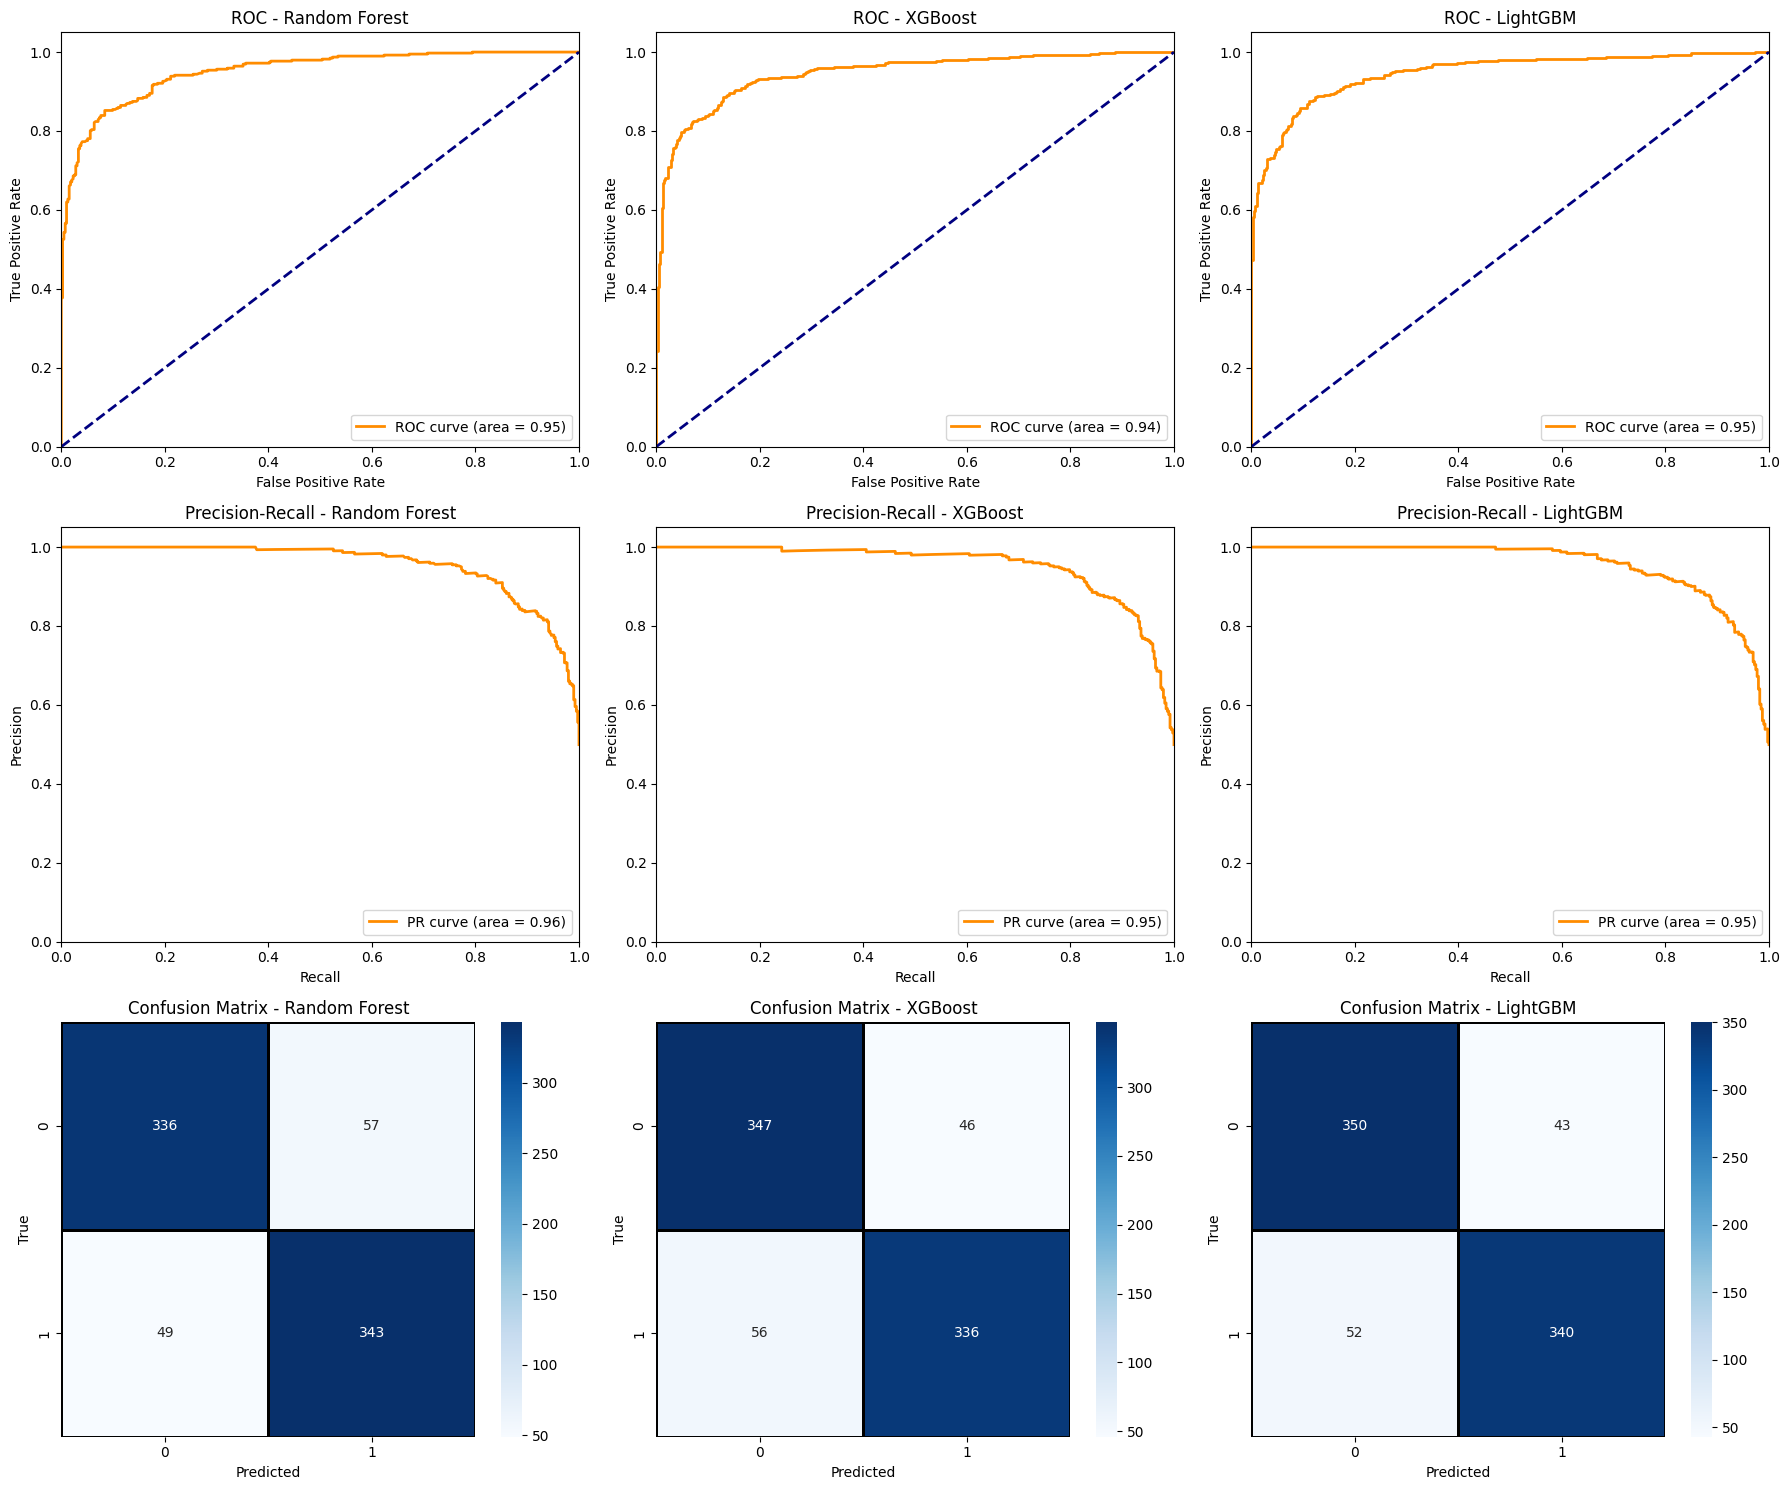

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

def plot_all_metrics(models, X_test, y_test, model_names):
    fig, axes = plt.subplots(nrows=3, ncols=len(models), figsize=(18, 15))
    
    for i, model in enumerate(models):
        # ROC Curve
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        axes[0, i].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        axes[0, i].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axes[0, i].set_xlim([0.0, 1.0])
        axes[0, i].set_ylim([0.0, 1.05])
        axes[0, i].set_xlabel('False Positive Rate')
        axes[0, i].set_ylabel('True Positive Rate')
        axes[0, i].set_title(f'ROC - {model_names[i]}')
        axes[0, i].legend(loc="lower right")
        
        # Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = auc(recall, precision)
        axes[1, i].plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
        axes[1, i].set_xlim([0.0, 1.0])
        axes[1, i].set_ylim([0.0, 1.05])
        axes[1, i].set_xlabel('Recall')
        axes[1, i].set_ylabel('Precision')
        axes[1, i].set_title(f'Precision-Recall - {model_names[i]}')
        axes[1, i].legend(loc="lower right")
        
        # Confusion Matrix
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=2, linecolor='black', ax=axes[2, i])
        axes[2, i].set_xlabel('Predicted')
        axes[2, i].set_ylabel('True')
        axes[2, i].set_title(f'Confusion Matrix - {model_names[i]}')

    plt.tight_layout()
    plt.savefig(os.path.join(visual_dir, f'metrics_{trial_number_ml}.png'))
    plt.show()

models = [best_rf, best_xgb, best_lgb]
model_names = ['Random Forest', 'XGBoost', 'LightGBM']
plot_all_metrics(models, X_test, y_test, model_names)


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

def plot_roc_curve(model, X_test, y_test, model_name='Model'):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

def plot_precision_recall_curve(model, X_test, y_test, model_name='Model'):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)

    plt.figure()
    plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(model, X_test, y_test, model_name='Model'):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=2, linecolor='black')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve

models = [best_rf, best_xgb, best_lgb]
model_names = ['Random Forest', 'XGBoost', 'LightGBM']
metrics_list = []

def evaluate_model_performance(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_pred_proba),
    }
    return metrics


# Plotting functions modified to save figures
def plot_and_save_figures(models, X_test, y_test, model_names, trial_number_ml):
    for model, model_name in zip(models, model_names):
        # ROC Curve
        plot_roc_curve(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'roc_curve_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()
        
        # Precision-Recall Curve
        plot_precision_recall_curve(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'precision_recall_curve_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()
        
        # Confusion Matrix
        plot_confusion_matrix(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'confusion_matrix_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()



In [12]:
# Evaluate and save metrics for each model
for model, name in zip(models, model_names):
    metrics = evaluate_model_performance(model, X_test, y_test, name)
    metrics_list.append(metrics)
    print(f"Metrics for {name}: {metrics}")

# Convert metrics to DataFrame sort bu 'Accuracy' and save
metrics_df = pd.DataFrame(metrics_list)
sorted_metrics_df = metrics_df.sort_values(by='Accuracy', ascending=False)
sorted_metrics_df.to_csv(os.path.join(results_dir, f'sorted_metrics_df_{trial_number_ml}.csv'), index=False)

Metrics for Random Forest: {'Model': 'Random Forest', 'Accuracy': 0.8649681528662421, 'Precision': 0.8575, 'Recall': 0.875, 'F1 Score': 0.8661616161616162, 'ROC AUC': 0.9500051929168614}
Metrics for XGBoost: {'Model': 'XGBoost', 'Accuracy': 0.870063694267516, 'Precision': 0.8795811518324608, 'Recall': 0.8571428571428571, 'F1 Score': 0.8682170542635659, 'ROC AUC': 0.944955081269149}
Metrics for LightGBM: {'Model': 'LightGBM', 'Accuracy': 0.8789808917197452, 'Precision': 0.8877284595300261, 'Recall': 0.8673469387755102, 'F1 Score': 0.8774193548387096, 'ROC AUC': 0.9461429610011944}


In [13]:
metrics

{'Model': 'LightGBM',
 'Accuracy': 0.8789808917197452,
 'Precision': 0.8877284595300261,
 'Recall': 0.8673469387755102,
 'F1 Score': 0.8774193548387096,
 'ROC AUC': 0.9461429610011944}

In [14]:
# Assuming you have a list called metrics_list which contains the metrics dictionaries for each model
# And assuming each dictionary has a 'Model' key with the model's name and an 'Accuracy' key with its accuracy

# Extract accuracy scores and model names from metrics_list
accuracy_scores = [metrics['Accuracy'] for metrics in metrics_list]
model_names = [metrics['Model'] for metrics in metrics_list]

# Find the index of the highest accuracy
best_model_index = accuracy_scores.index(max(accuracy_scores))

# Retrieve the best model and its name using the index
best_model = models[best_model_index]
best_model_name = model_names[best_model_index]

# Print the best model name and its accuracy
print(f"Best Model: {best_model_name} with Accuracy: {accuracy_scores[best_model_index]:.4f}")


Best Model: LightGBM with Accuracy: 0.8790


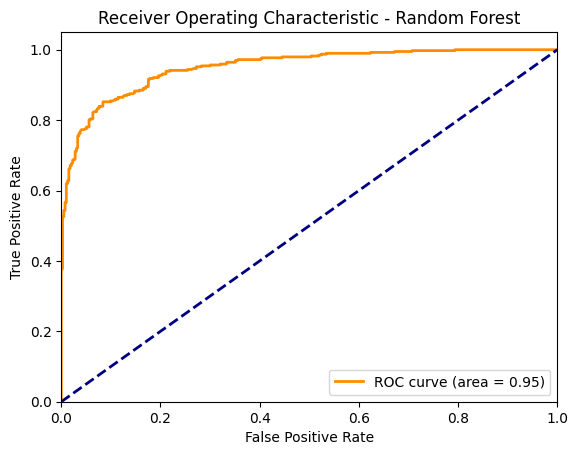

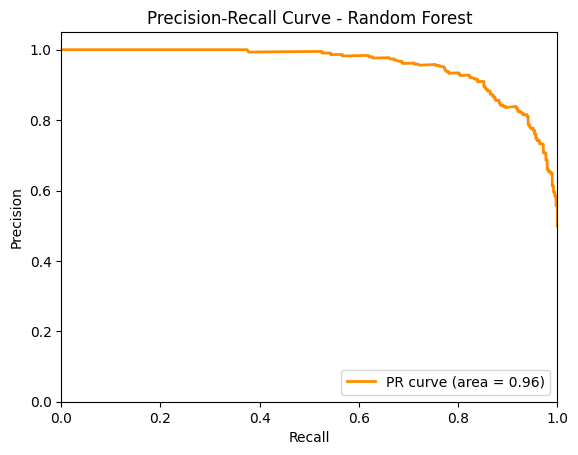

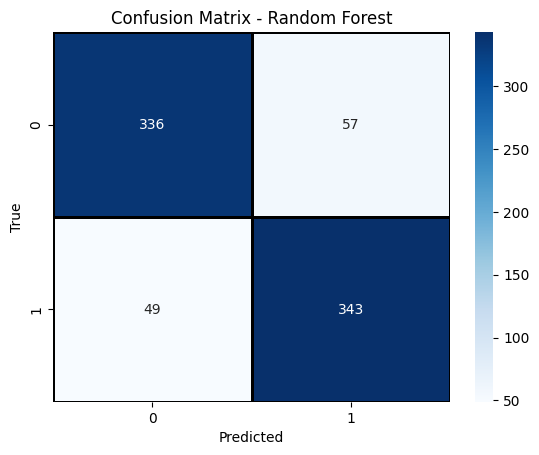

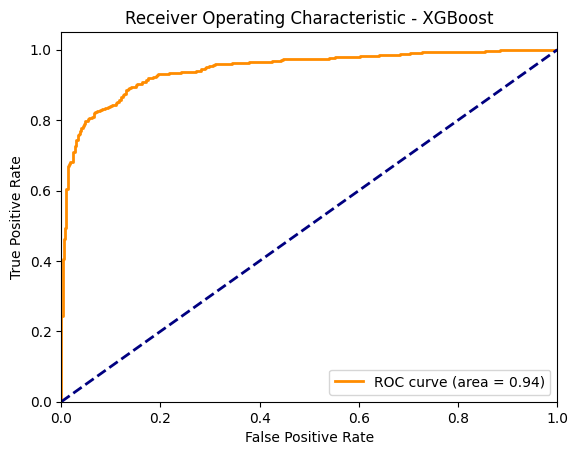

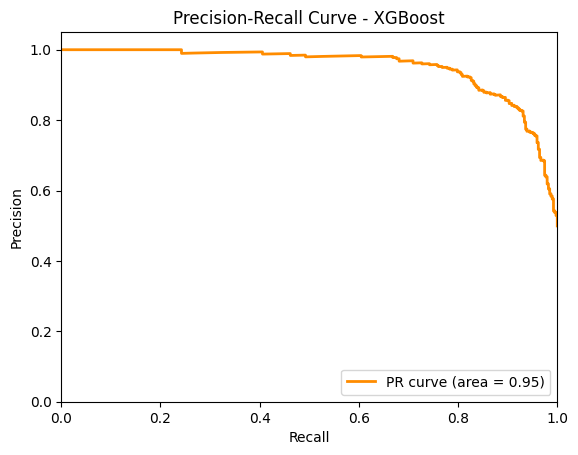

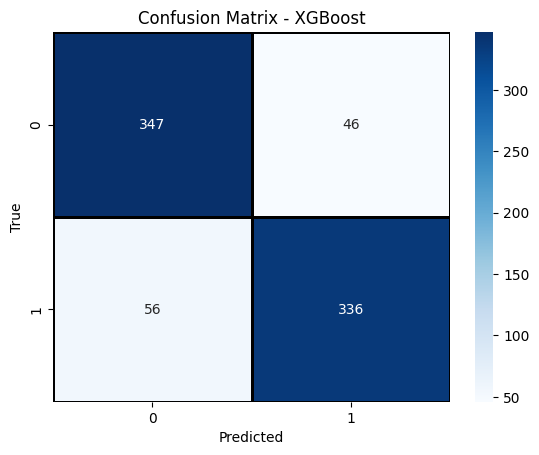

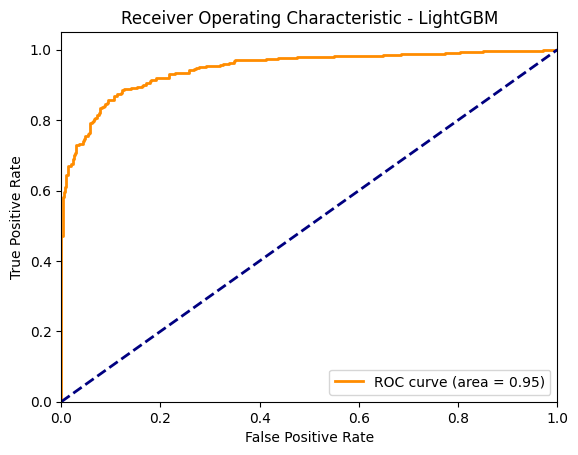

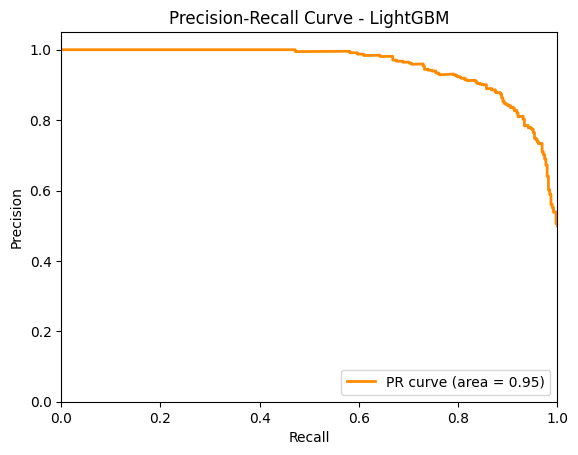

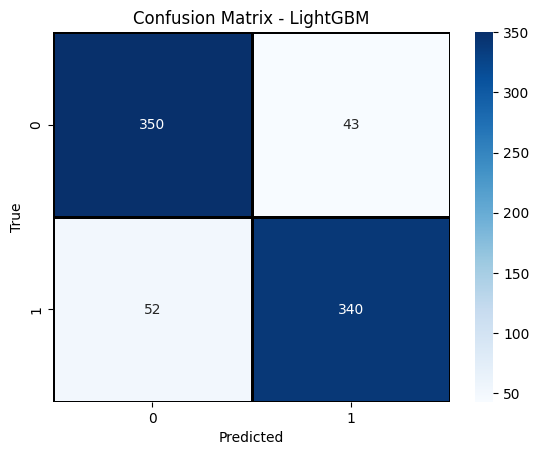

In [15]:
plot_and_save_figures(models, X_test, y_test, model_names, trial_number_ml)


In [16]:
def extract_feature_importances(model, feature_names):
    """
    Extract and sort the feature importances from the model.
    """
    feature_importances = model.feature_importances_
    sorted_idx = np.argsort(feature_importances)[::-1]
    return feature_names[sorted_idx], feature_importances[sorted_idx]

def plot_feature_importances(feature_names, feature_importances, title='Feature Importances', n_features=20):
    """
    Visualize the top N feature importances for interpretability.
    """
    plt.figure(figsize=(10, 8))
    sns.barplot(x=feature_importances[:n_features], y=feature_names[:n_features], orient='h')
    plt.title(title)
    plt.xlabel('Importance')
    plt.ylabel('Feature (Bit Index)')
    plt.savefig(os.path.join(features_dir, f'feature_importances_{trial_number_ml}.png'), dpi=300)
    plt.show()

def identify_important_features(feature_names, feature_importances, threshold=0.002):
    """
    Identify features with importance greater than a specified threshold.
    """
    return feature_names[feature_importances > threshold], feature_importances[feature_importances > threshold]

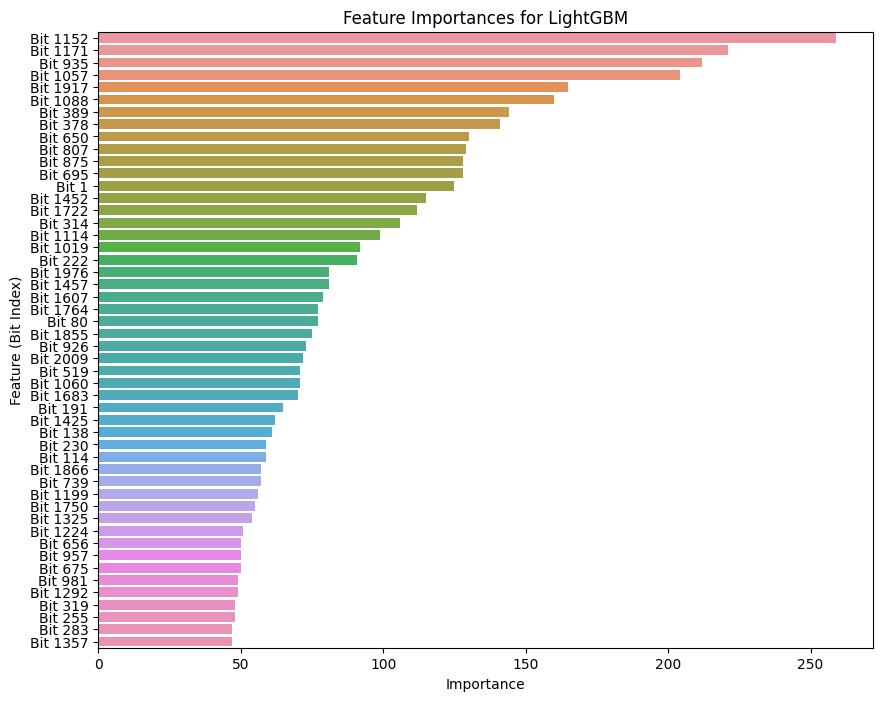

In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib

feature_names = np.array(["Bit " + str(i) for i in range(X_train.shape[1])])  # Adjust based on your X_train


def save_feature_importances(model, feature_names, model_name, trial_number):
    sorted_names, sorted_importances = extract_feature_importances(model, feature_names)
    
    # Save to CSV
    features_df = pd.DataFrame({
        'Feature': sorted_names,
        'Importance': sorted_importances
    })
    csv_path = os.path.join(features_dir, f'feature_importances_{model_name}_{trial_number}.csv')
    features_df.to_csv(csv_path, index=False)
    
    # Plot and save visualization
    plot_feature_importances(sorted_names, sorted_importances, f'Feature Importances for {model_name}', n_features=50)
    plt.close()

save_feature_importances(best_model, feature_names, best_model_name, trial_number_ml)


In [18]:
import time

def save_feature_importances(model, feature_names, model_name, trial_number):
    sorted_names, sorted_importances = extract_feature_importances(model, feature_names)
    
    # Define file paths
    timestamp = time.strftime("%Y%m%d-%H%M%S")  # Current timestamp
    csv_filename = f'feature_importances_{model_name}_{trial_number}.csv'
    plot_filename = f'feature_importances_plot_{model_name}_{trial_number}.png'
    
    # Check if files exist and append timestamp to avoid overwriting
    csv_path = os.path.join(features_dir, csv_filename)
    if os.path.exists(csv_path):
        csv_path = os.path.join(features_dir, f'feature_importances_{model_name}_{trial_number}_{timestamp}.csv')
    
    plot_path = os.path.join(features_dir, plot_filename)
    if os.path.exists(plot_path):
        plot_path = os.path.join(features_dir, f'feature_importances_plot_{model_name}_{trial_number}_{timestamp}.png', dpi=300)

    # Save to CSV
    features_df = pd.DataFrame({'Feature': sorted_names, 'Importance': sorted_importances})
    features_df.to_csv(csv_path, index=False)
    
    # Plot and save visualization
    plot_feature_importances(sorted_names, sorted_importances, f'Feature Importances for {model_name}', n_features=20)
    plt.savefig(plot_path)
    plt.close()
